<a href="https://colab.research.google.com/github/AidenWisch/F1-2025-Championship-Predictor/blob/main/f1predictor0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
import time
import json
import warnings
import pmdarima as pm
import matplotlib.pyplot as plt
import pytz


warnings.filterwarnings('ignore')

In [ ]:
Open_f1_data_url = "https://api.openf1.org/v1"
sim_date = datetime(2025, 10, 8)
season = sim_date.year


training_seasons = [2023, 2024, 2025]
points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
driver_numbers = [1, 4, 5, 6, 7, 10, 12, 14, 16, 18, 22, 23, 27, 30, 31, 43, 44, 55, 63, 81, 87]
api_delay = 0.3  # seconds between requests


In [ ]:
def make_api_request(endpoint, params=None):
    """Make a request to OpenF1 API with error handling"""
    try:
        url = f"{Open_f1_data_url}/{endpoint}"
        time.sleep(api_delay)  # Rate limiting
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f" API request failed: {str(e)[:100]}")
        return None

In [ ]:
def get_sessions_for_year(year):
    """Get all race sessions for a given year"""
    print(f"Fetching {year} session data...")

    params = {
        'year': year,
        'session_name': 'Race'
    }

    sessions = make_api_request('sessions', params)
    if sessions is None:
        return []

    print(f"  ✓ Found {len(sessions)} race sessions for {year}")
    return sessions
print(get_sessions_for_year(2025))


Fetching 2025 session data...
  ✓ Found 24 race sessions for 2025
[{'meeting_key': 1254, 'session_key': 9693, 'location': 'Melbourne', 'date_start': '2025-03-16T04:00:00+00:00', 'date_end': '2025-03-16T06:00:00+00:00', 'session_type': 'Race', 'session_name': 'Race', 'country_key': 5, 'country_code': 'AUS', 'country_name': 'Australia', 'circuit_key': 10, 'circuit_short_name': 'Melbourne', 'gmt_offset': '11:00:00', 'year': 2025}, {'meeting_key': 1255, 'session_key': 9998, 'location': 'Shanghai', 'date_start': '2025-03-23T07:00:00+00:00', 'date_end': '2025-03-23T09:00:00+00:00', 'session_type': 'Race', 'session_name': 'Race', 'country_key': 53, 'country_code': 'CHN', 'country_name': 'China', 'circuit_key': 49, 'circuit_short_name': 'Shanghai', 'gmt_offset': '08:00:00', 'year': 2025}, {'meeting_key': 1256, 'session_key': 10006, 'location': 'Suzuka', 'date_start': '2025-04-06T05:00:00+00:00', 'date_end': '2025-04-06T07:00:00+00:00', 'session_type': 'Race', 'session_name': 'Race', 'country_k

In [ ]:
def get_race_results(session_key):
    """Get race results for a specific session"""
    params = {'session_key': session_key}
    # We use the position endpoint to get the final standing
    # This returns all position updates, so we take the last one for each driver
    positions = make_api_request('position', params)

    df = pd.DataFrame(positions)
    if df.empty:
        return None

    # Get final positions (last entry for each driver)
    # We sort by date to ensure we get the latest update
    final_positions = df.sort_values('date').groupby('driver_number').last().reset_index()
    return final_positions

def get_season_race_results(year):
    sessions = get_sessions_for_year(year)
    all_results = []

    if not sessions:
        return pd.DataFrame()

    print(f"Processing {len(sessions)} races for {year}...")

    for session in sessions:
        session_key = session['session_key']
        race_name = session.get('location', f"Race {session_key}")

        print(f"  Fetching results for {race_name}...")
        results = get_race_results(session_key)

        if results is not None and not results.empty:
            results['year'] = year
            results['race_name'] = race_name
            results['session_key'] = session_key
            results['round'] = session.get('meeting_key')
            all_results.append(results)

    if not all_results:
        return pd.DataFrame()

    return pd.concat(all_results, ignore_index=True)

In [ ]:
temp2025 = get_season_race_results(2025)

Fetching 2025 session data...
  ✓ Found 24 race sessions for 2025
Processing 24 races for 2025...
  Fetching results for Melbourne...
  Fetching results for Shanghai...
  Fetching results for Suzuka...
  Fetching results for Sakhir...
  Fetching results for Jeddah...
  Fetching results for Miami...
  Fetching results for Imola...
  Fetching results for Monaco...
  Fetching results for Barcelona...
  Fetching results for Montréal...
  Fetching results for Spielberg...
  Fetching results for Silverstone...
  Fetching results for Spa-Francorchamps...
  Fetching results for Budapest...
  Fetching results for Zandvoort...
  Fetching results for Monza...
  Fetching results for Baku...
  Fetching results for Marina Bay...
  Fetching results for Austin...
  Fetching results for Mexico City...
  Fetching results for São Paulo...
  Fetching results for Las Vegas...
  Fetching results for Lusail...
  Fetching results for Yas Island...


In [ ]:
temp2025['date'] = pd.to_datetime(temp2025['date'])
sim_date_aware = sim_date.replace(tzinfo=pytz.UTC)
temp2025 = temp2025[temp2025['date'] <= sim_date_aware]
print(temp2025['race_name'].unique())

#temp2025[temp2025['date'] <= sim_date]

['Melbourne' 'Shanghai' 'Suzuka' 'Sakhir' 'Jeddah' 'Miami' 'Imola'
 'Monaco' 'Barcelona' 'Montréal' 'Spielberg' 'Silverstone'
 'Spa-Francorchamps' 'Budapest' 'Zandvoort' 'Monza' 'Baku' 'Marina Bay']


In [ ]:
start_year = 2023
end_year = sim_date.year

def getData(start_year, end_year):
    all_race_data = []

    for year in range(start_year, end_year + 1):
        print(f"\nProcessing Season {year}...")
        season_df = get_season_race_results(year)

        if not season_df.empty:
            all_race_data.append(season_df)

    if all_race_data:
        full_df = pd.concat(all_race_data, ignore_index=True)

        # Convert date column to datetime
        full_df['date'] = pd.to_datetime(full_df['date'])
        return(full_df)
    else:
        print("No data found.")
        return()

def filterToSimDate(full_df, sim_date):
        # Filter by sim_date
        # Handle timezone awareness if necessary
        #if full_df['date'].dt.tz is not None:
            # If data is tz-aware, make sim_date tz-aware (UTC)
            #import pytz
            #sim_date_aware = sim_date.replace(tzinfo=pytz.UTC)
            #full_df = full_df[full_df['date'] <= sim_date_aware]
        #else:
            #full_df = full_df[full_df['date'] <= sim_date]
    sim_date_aware = sim_date.replace(tzinfo=pytz.UTC)
    full_df = full_df[full_df['date'] <= sim_date_aware]

    #print(f"\nTotal records fetched: {len(full_df)}")
    #print(f"Unique drivers: {full_df['driver_number'].nunique()}")
    #print(full_df.head())
    return(full_df)


In [ ]:
full_df_all_dates = getData(start_year, end_year)
full_df = filterToSimDate(full_df_all_dates, sim_date)


Processing Season 2023...
Fetching 2023 session data...
  ✓ Found 22 race sessions for 2023
Processing 22 races for 2023...
  Fetching results for Sakhir...
  Fetching results for Jeddah...
  Fetching results for Melbourne...
  Fetching results for Baku...
  Fetching results for Miami...
  Fetching results for Monaco...
  Fetching results for Barcelona...
  Fetching results for Montréal...
  Fetching results for Spielberg...
  Fetching results for Silverstone...
  Fetching results for Budapest...
  Fetching results for Spa-Francorchamps...
  Fetching results for Zandvoort...
  Fetching results for Monza...
  Fetching results for Marina Bay...
  Fetching results for Suzuka...
  Fetching results for Lusail...
  Fetching results for Austin...
  Fetching results for Mexico City...
  Fetching results for São Paulo...
  Fetching results for Las Vegas...
  Fetching results for Yas Island...

Processing Season 2024...
Fetching 2024 session data...
  ✓ Found 24 race sessions for 2024
Processin

In [ ]:
#print(full_df_all_dates[full_df_all_dates['year']==2025]['race_name'].unique())

In [ ]:
# Calculate points based on position using the points_system dictionary
full_df['points'] = full_df['position'].apply(lambda x: points_system.get(int(x), 0) if pd.notnull(x) and str(x).isdigit() else 0)
full_df_all_dates['points'] = full_df_all_dates['position'].apply(lambda x: points_system.get(int(x), 0) if pd.notnull(x) and str(x).isdigit() else 0)

# Sort by driver and date to show chronological progression
sorted_df = full_df.sort_values(by=['driver_number', 'date'])
sorted_df_all_dates = full_df_all_dates.sort_values(by=['driver_number', 'date'])

# Select and rename columns to match the requested format: driver race points
driver_points_df = sorted_df[['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})

# Create separate dataframes for each year
#driver_points_df_2022 = sorted_df[sorted_df['year'] == 2022][['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})
driver_points_df_2023 = sorted_df[sorted_df['year'] == 2023][['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})
driver_points_df_2024 = sorted_df[sorted_df['year'] == 2024][['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})
driver_points_df_2025 = sorted_df[sorted_df['year'] == 2025][['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})
driver_points_df_2025_full = sorted_df_all_dates[sorted_df_all_dates['year'] == 2025][['driver_number', 'race_name', 'points']].rename(columns={'driver_number': 'driver', 'race_name': 'race'})

# Display the resulting dataframes
print("Overall Driver Points (Head):")
print(driver_points_df.head())
print("\n2023 Driver Points (Head):")
print(driver_points_df_2023.head())
print("\n2024 Driver Points (Head):")
print(driver_points_df_2024.head())
print("\n2025 Driver Points (Head):")
print(driver_points_df_2025.head())

# Save to CSV
driver_points_df_2023.to_csv('driver_points_2023.csv', index=False)
driver_points_df_2024.to_csv('driver_points_2024.csv', index=False)
driver_points_df_2025.to_csv('driver_points_2025.csv', index=False)
print("\nSaved 2023, 2024, and 2025 driver points to CSV files.")


Overall Driver Points (Head):
    driver       race  points
0        1     Sakhir      25
20       1     Jeddah      18
40       1  Melbourne      25
60       1       Baku      18
80       1      Miami      25

2023 Driver Points (Head):
    driver       race  points
0        1     Sakhir      25
20       1     Jeddah      18
40       1  Melbourne      25
60       1       Baku      18
80       1      Miami      25

2024 Driver Points (Head):
     driver       race  points
439       1     Sakhir      25
459       1     Jeddah      25
479       1  Melbourne       0
498       1     Suzuka      25
518       1   Shanghai      25

2025 Driver Points (Head):
     driver       race  points
918       1  Melbourne      18
938       1   Shanghai      12
958       1     Suzuka      25
978       1     Sakhir       8
998       1     Jeddah      18

Saved 2023, 2024, and 2025 driver points to CSV files.


In [ ]:
remaining_races = ["United States", "Mexico", "Brazil", "Las Vegas", "Qatar", "Abu Dhabi"]
n_forecast = len(remaining_races)

driver_models = {}
driver_forecasts = {}

print(f"Training models and forecasting for {len(driver_numbers)} drivers over {n_forecast} races...")

for driver in driver_numbers:
    # Filter data for the specific driver from the full dataset
    driver_data = driver_points_df[driver_points_df['driver'] == driver]
    y_train = driver_data['points']

    # Ensure we have enough data points to train
    if len(y_train) < 3:
        # print(f"Skipping driver {driver}: Not enough data points ({len(y_train)})")
        continue

    try:
        # Fit the auto_arima model
        model = pm.auto_arima(
            y_train,
            start_p=1,
            start_q=1,
            max_p=5,
            max_q=5,
            d=None,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore'
        )

        driver_models[driver] = model

        # Forecast for the remaining races
        forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)

        # Store forecast mapped to race names
        driver_forecasts[driver] = dict(zip(remaining_races, forecast))

    except Exception as e:
        print(f"Error training model for driver {driver}: {e}")

print(f"Successfully trained models for {len(driver_models)} drivers.")


Training models and forecasting for 21 drivers over 6 races...
Successfully trained models for 21 drivers.


In [ ]:
# Create a DataFrame from the raw ARIMA forecasts
raw_forecast_df = pd.DataFrame.from_dict(driver_forecasts, orient='index')
raw_forecast_df = raw_forecast_df[remaining_races]

# Create a new DataFrame for the final championship points
final_points_df = pd.DataFrame(index=raw_forecast_df.index, columns=remaining_races)

print("Applying points system to forecasted race results...")

# Apply points system to each race
for race in remaining_races:
    # Sort drivers by forecasted raw value descending (highest predicted performance wins)
    race_results = raw_forecast_df[race].sort_values(ascending=False)

    # Assign points based on rank
    for rank, (driver, _) in enumerate(race_results.items(), start=1):
        points = points_system.get(rank, 0)
        final_points_df.loc[driver, race] = points


final_points_df.index.name = 'Driver'
print("\nPredicted Race Points (after applying scoring system):")
print(final_points_df)

# Save to CSV
final_points_df.to_csv('predicted_race_points.csv')
print("\nSaved predicted points to 'predicted_race_points.csv'")


Applying points system to forecasted race results...

Predicted Race Points (after applying scoring system):
       United States Mexico Brazil Las Vegas Qatar Abu Dhabi
Driver                                                      
1                 25     25     25        25    25        25
4                 15     15     12        12    15        15
5                  0      0      0         0     0         0
6                  1      0      1         0     0         1
7                  0      0      0         0     0         0
10                 0      0      0         0     0         0
12                 6      2      4         6     4         6
14                 0      0      0         0     0         0
16                12     12     10        10    10        10
18                 0      0      0         0     0         0
22                 0      0      0         0     0         0
23                 0      4      6         4     2         2
27                 0      0      0   

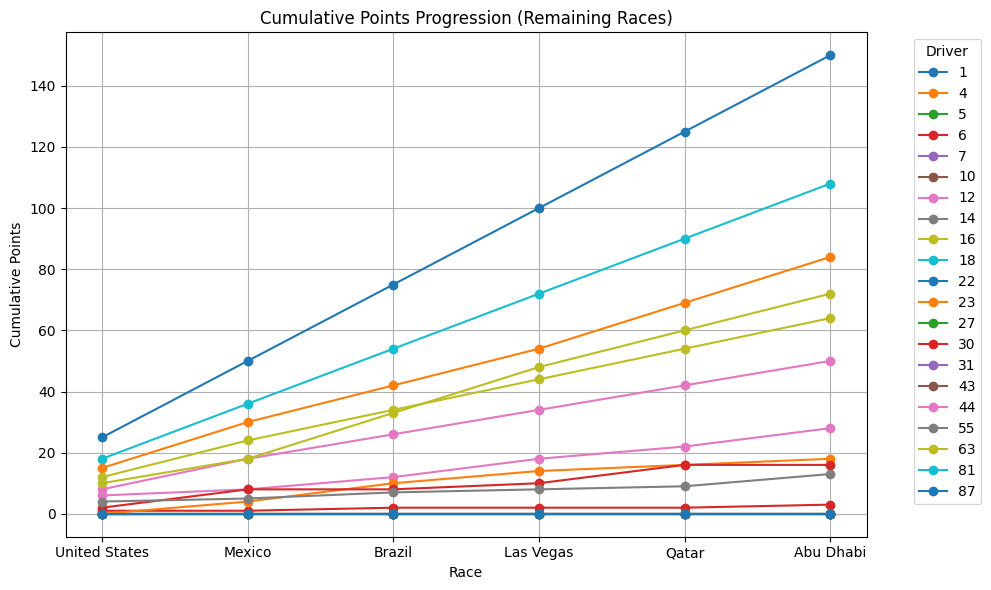

In [ ]:
from typing_extensions import final
cumulative_points = final_points_df.cumsum(axis=1).T

plt.figure(figsize=(10, 6))
cumulative_points.plot(marker='o', ax=plt.gca())
plt.title('Cumulative Points Progression (Remaining Races)')
plt.xlabel('Race')
plt.ylabel('Cumulative Points')
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

formatted_df = driver_points_df_2025.pivot(index='driver', columns='race', values='points').fillna(0)
print(formatted_df)



race    Baku  Barcelona  Budapest  Imola  Jeddah  Marina Bay  Melbourne  \
driver                                                                    
1       25.0        1.0       2.0   25.0    18.0        18.0       18.0   
4        6.0       18.0      25.0   18.0    12.0        15.0       25.0   
5        0.0        0.0       8.0    0.0     0.0         0.0        0.0   
6        1.0        6.0       0.0    2.0     1.0         0.0        0.0   
7        0.0        0.0       0.0    0.0     0.0         0.0        0.0   
10       0.0        4.0       0.0    0.0     0.0         0.0        0.0   
12      12.0        0.0       1.0    0.0     8.0        10.0       10.0   
14       0.0        2.0      10.0    0.0     0.0         4.0        0.0   
16       2.0       15.0      12.0    8.0    15.0         8.0        4.0   
18       0.0        0.0       6.0    0.0     0.0         0.0        8.0   
22       8.0        0.0       0.0    1.0     0.0         0.0        0.0   
23       0.0        0.0  

In [ ]:
temp1 = formatted_df.reset_index()
temp2 = final_points_df.reset_index()
temp2.rename(columns={'Driver':'driver'}, inplace=True)
#print(temp1['driver'])

order = driver_points_df_2025[driver_points_df_2025['driver']==1]['race'].values.tolist()
order.insert(0, 'driver')
#Need to apply orders to columns
temp1 = temp1[order]

In [ ]:
print(temp1)

race  driver  Melbourne  Shanghai  Suzuka  Sakhir  Jeddah  Miami  Imola  \
0          1       18.0      12.0    25.0     8.0    18.0   12.0   25.0   
1          4       25.0      18.0    18.0    15.0    12.0   18.0   18.0   
2          5        0.0       0.0     0.0     0.0     0.0    0.0    0.0   
3          6        0.0       0.0     4.0     0.0     1.0    0.0    2.0   
4          7        0.0       0.0     0.0     0.0     0.0    0.0    0.0   
5         10        0.0       0.0     0.0     6.0     0.0    0.0    0.0   
6         12       10.0       4.0     8.0     0.0     8.0    8.0    0.0   
7         14        0.0       0.0     0.0     0.0     0.0    0.0    0.0   
8         16        4.0      10.0    12.0    12.0    15.0    6.0    8.0   
9         18        8.0       0.0     0.0     0.0     0.0    0.0    0.0   
10        22        0.0       0.0     0.0     2.0     0.0    1.0    1.0   
11        23       12.0       2.0     2.0     0.0     2.0   10.0   10.0   
12        27        6.0  

In [ ]:
temp3 = pd.merge(temp1, temp2, how='outer', on='driver')

In [ ]:
print(temp3)

    driver  Melbourne  Shanghai  Suzuka  Sakhir  Jeddah  Miami  Imola  Monaco  \
0        1       18.0      12.0    25.0     8.0    18.0   12.0   25.0    12.0   
1        4       25.0      18.0    18.0    15.0    12.0   18.0   18.0    25.0   
2        5        0.0       0.0     0.0     0.0     0.0    0.0    0.0     0.0   
3        6        0.0       0.0     4.0     0.0     1.0    0.0    2.0     8.0   
4        7        0.0       0.0     0.0     0.0     0.0    0.0    0.0     0.0   
5       10        0.0       0.0     0.0     6.0     0.0    0.0    0.0     0.0   
6       12       10.0       4.0     8.0     0.0     8.0    8.0    0.0     0.0   
7       14        0.0       0.0     0.0     0.0     0.0    0.0    0.0     0.0   
8       16        4.0      10.0    12.0    12.0    15.0    6.0    8.0    18.0   
9       18        8.0       0.0     0.0     0.0     0.0    0.0    0.0     0.0   
10      22        0.0       0.0     0.0     2.0     0.0    1.0    1.0     0.0   
11      23       12.0       

In [ ]:
temp3.set_index('driver', inplace=True)

In [ ]:
temp3

,Melbourne,Shanghai,Suzuka,Sakhir,Jeddah,Miami,Imola,Monaco,Barcelona,Montréal,...,Zandvoort,Monza,Baku,Marina Bay,United States,Mexico,Brazil,Las Vegas,Qatar,Abu Dhabi
driver,,,,,,,,,,,,,,,,,,,,,
1,18.0,12.0,25.0,8.0,18.0,12.0,25.0,12.0,1.0,18.0,...,18.0,25.0,25.0,18.0,25,25,25,25,25,25
4,25.0,18.0,18.0,15.0,12.0,18.0,18.0,25.0,18.0,0.0,...,0.0,18.0,6.0,15.0,15,15,12,12,15,15
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0,0,0,0,0,0
6,0.0,0.0,4.0,0.0,1.0,0.0,2.0,8.0,6.0,0.0,...,15.0,1.0,1.0,0.0,1,0,1,0,0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
10,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
12,10.0,4.0,8.0,0.0,8.0,8.0,0.0,0.0,0.0,15.0,...,0.0,2.0,12.0,10.0,6,2,4,6,4,6
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,...,4.0,0.0,0.0,4.0,0,0,0,0,0,0
16,4.0,10.0,12.0,12.0,15.0,6.0,8.0,18.0,15.0,10.0,...,0.0,12.0,2.0,8.0,12,12,10,10,10,10


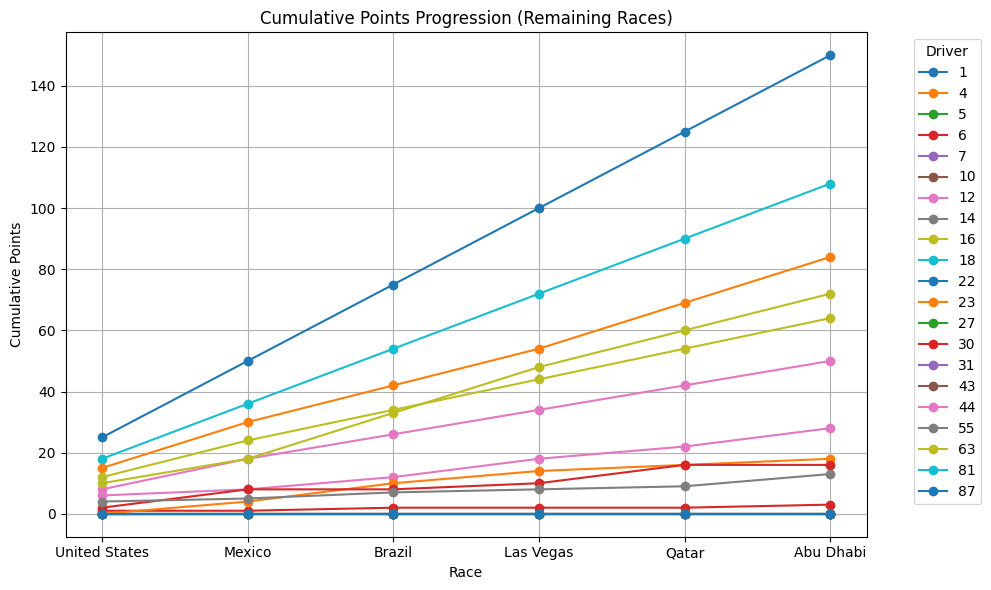

In [ ]:
from typing_extensions import final
cumulative_points = final_points_df.cumsum(axis=1).T

plt.figure(figsize=(10, 6))
cumulative_points.plot(marker='o', ax=plt.gca())
plt.title('Cumulative Points Progression (Remaining Races)')
plt.xlabel('Race')
plt.ylabel('Cumulative Points')
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cumPoints = temp3.cumsum(axis=1)
cumulative_points = cumPoints[cumPoints['Abu Dhabi']>100].T
#cumulative_points.iloc[23]>100
cumulative_points.columns




Index([1, 4, 12, 16, 44, 63, 81], dtype='int64', name='driver')

In [ ]:
noPrediction = temp1
noPrediction = noPrediction[noPrediction['driver'].isin(cumulative_points.columns)]
noPrediction.set_index('driver', inplace=True)
noPrediction = noPrediction.cumsum(axis=1).T
noPrediction


#cumulative_points = cumPoints[cumPoints['Abu Dhabi']>100].T
#cumulative_points.iloc[23]>100
#cumulative_points.columns

driver,1,4,12,16,44,63,81
race,,,,,,,
Melbourne,18.0,25.0,10.0,4.0,1.0,15.0,2.0
Shanghai,30.0,43.0,14.0,14.0,9.0,30.0,27.0
Suzuka,55.0,61.0,22.0,26.0,15.0,40.0,42.0
Sakhir,63.0,76.0,22.0,38.0,25.0,58.0,67.0
Jeddah,81.0,88.0,30.0,53.0,31.0,68.0,92.0
Miami,93.0,106.0,38.0,59.0,35.0,83.0,117.0
Imola,118.0,124.0,38.0,67.0,47.0,89.0,132.0
Monaco,130.0,149.0,38.0,85.0,57.0,89.0,147.0
Barcelona,131.0,167.0,38.0,100.0,65.0,101.0,172.0


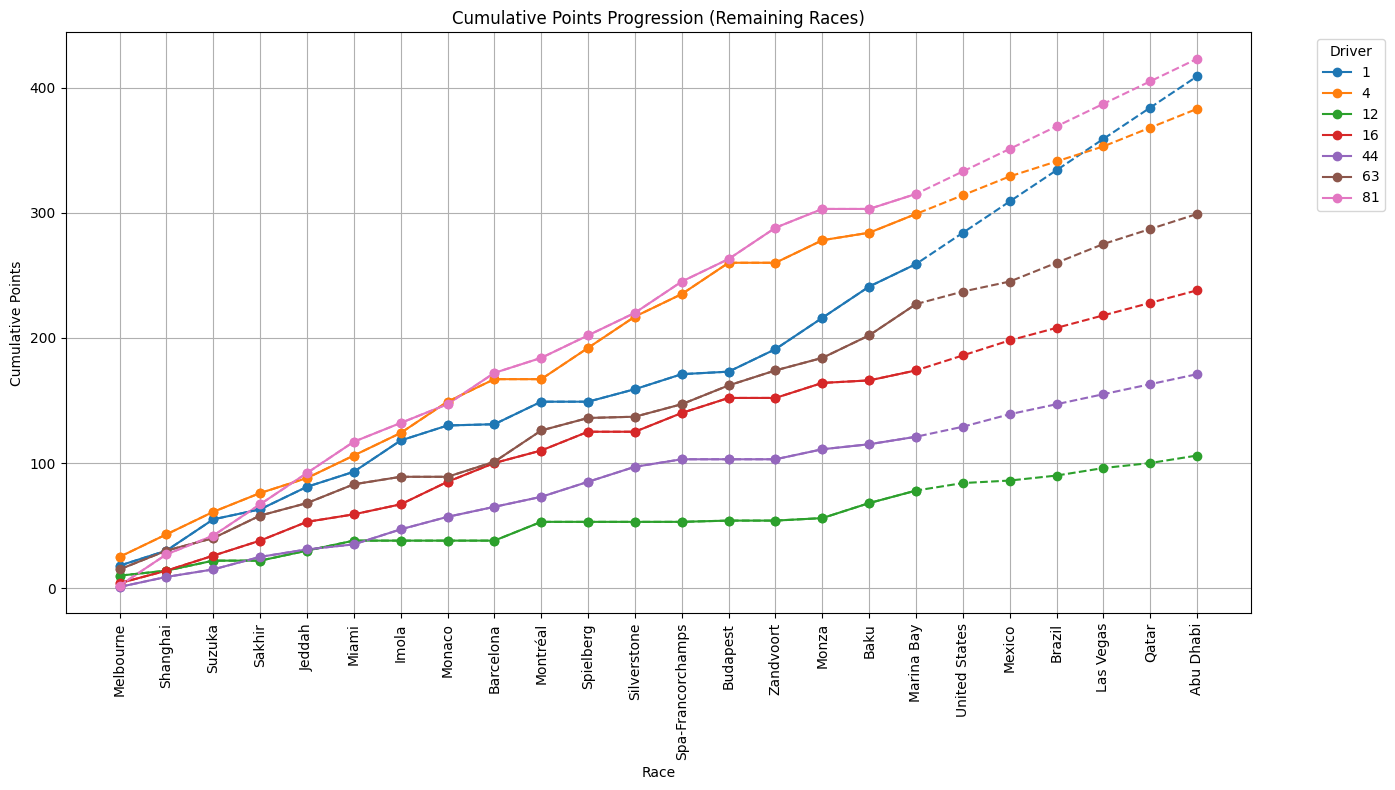

In [ ]:
from typing_extensions import final
cumulative_points# = temp3.cumsum(axis=1).T
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

plt.figure(figsize=(14, 8))
noPrediction.plot(marker='o', ax=plt.gca(), linestyle='-', color=colors)
cumulative_points.plot(marker='o', ax=plt.gca(), linestyle='--', color=colors)
plt.title('Cumulative Points Progression (Remaining Races)')
plt.xlabel('Race')
plt.ylabel('Cumulative Points')
plt.legend(cumulative_points.columns.values, title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks = range(len(cumulative_points.index)), labels = cumulative_points.index, rotation = 90)
plt.tight_layout()
plt.show()

In [ ]:
cumulative_2025

driver,1,4,12,16,44,63,81
race,,,,,,,
Melbourne,18.0,25.0,10.0,4.0,1.0,15.0,2.0
Shanghai,30.0,43.0,14.0,14.0,9.0,30.0,27.0
Suzuka,55.0,61.0,22.0,26.0,15.0,40.0,42.0
Sakhir,63.0,76.0,22.0,38.0,25.0,58.0,67.0
Jeddah,81.0,88.0,30.0,53.0,31.0,68.0,92.0
Miami,93.0,106.0,38.0,59.0,35.0,83.0,117.0
Imola,118.0,124.0,38.0,67.0,47.0,89.0,132.0
Monaco,130.0,149.0,38.0,85.0,57.0,89.0,147.0
Barcelona,131.0,167.0,38.0,100.0,65.0,101.0,172.0


In [ ]:
first_races = cumulative_2025.index.values.tolist()[:-9]

In [ ]:
first_races

['Melbourne',
 'Shanghai',
 'Suzuka',
 'Sakhir',
 'Jeddah',
 'Miami',
 'Imola',
 'Monaco',
 'Barcelona',
 'Montréal',
 'Spielberg',
 'Silverstone',
 'Spa-Francorchamps',
 'Budapest',
 'Zandvoort']

In [ ]:
cumulative_2025_trimmed = cumulative_2025.drop(first_races, axis=0)
cumulative_2025_trimmed

driver,1,4,12,16,44,63,81
race,,,,,,,
Monza,216.0,278.0,56.0,164.0,111.0,184.0,303.0
Baku,241.0,284.0,68.0,166.0,115.0,202.0,303.0
Marina Bay,259.0,299.0,78.0,174.0,121.0,227.0,315.0
Austin,284.0,317.0,78.0,189.0,133.0,235.0,325.0
Mexico City,299.0,342.0,86.0,207.0,137.0,241.0,335.0
São Paulo,314.0,367.0,104.0,207.0,137.0,253.0,345.0
Las Vegas,339.0,385.0,114.0,215.0,138.0,268.0,357.0
Lusail,364.0,397.0,124.0,219.0,138.0,276.0,375.0
Yas Island,389.0,412.0,124.0,231.0,142.0,286.0,393.0


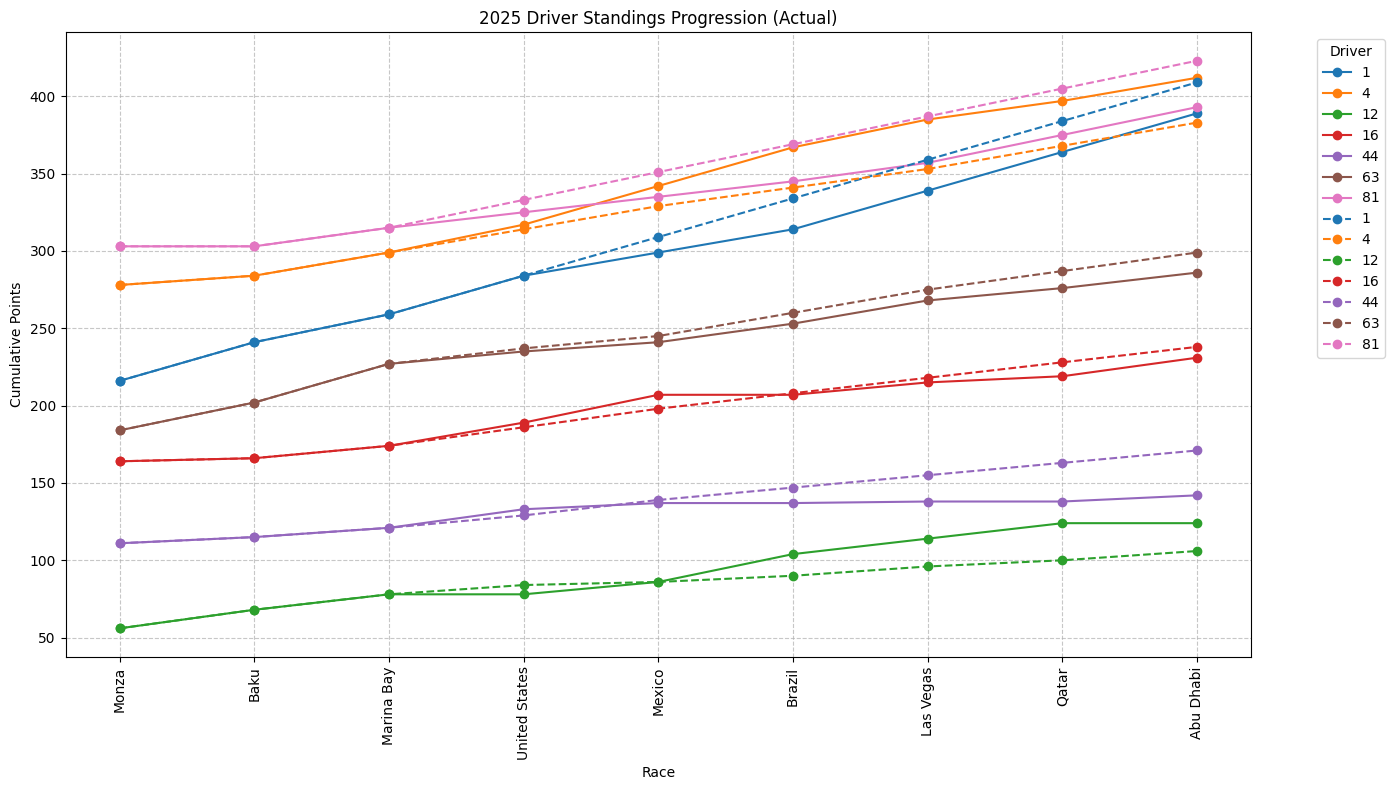

In [ ]:
race_order = driver_points_df_2025_full['race'].unique()

pivot_2025 = driver_points_df_2025_full.pivot(index='driver', columns='race', values='points').fillna(0)
pivot_2025 = pivot_2025.reindex(columns=race_order).reset_index()
pivot_2025 = pivot_2025[pivot_2025['driver'].isin(cumulative_points.columns)]
pivot_2025.set_index('driver', inplace=True)

cumulative_2025 = pivot_2025.cumsum(axis=1).T

first_races = cumulative_2025.index.values.tolist()[:-9]

cumulative_2025_trimmed = cumulative_2025.drop(first_races, axis=0)

cumulative_points_trimmed = cumulative_points.drop(first_races, axis=0)



plt.figure(figsize=(14, 8))
cumulative_2025_trimmed.plot(marker='o', ax=plt.gca(), linestyle='-', color=colors)
cumulative_points_trimmed.plot(marker='o', ax=plt.gca(), linestyle='--', color=colors)

plt.title('2025 Driver Standings Progression (Actual)')
plt.xlabel('Race')
plt.ylabel('Cumulative Points')
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ticks = range(len(cumulative_points_trimmed.index)), labels = cumulative_points_trimmed.index, rotation = 90)
plt.tight_layout()
plt.show()
